In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import gensim.downloader as api

# Load Gensim word embeddings
word_vectors = api.load("glove-wiki-gigaword-100")  # Load GloVe embeddings (100 dimensions)


c:\Users\Anirudh Verma\AppData\Local\Programs\Python\Python312\Lib\site-packages\paramiko\pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\Anirudh Verma\AppData\Local\Programs\Python\Python312\Lib\site-packages\paramiko\transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [2]:
fashion_mnist_classes = [
    "shirt", "trouser", "pullover", "dress", "coat",
    "sandal", "shirt", "sneaker", "bag", "boot"
]

# Rest of your code remains the same

# Define a mapping from FashionMNIST classes to word embeddings
# def get_semantic_embedding(labels, word_vectors):
#     return torch.stack([torch.tensor(word_vectors[fashion_mnist_classes[label]]) for label in labels], dim=0)
class_to_index = {cls: idx for idx, cls in enumerate(fashion_mnist_classes)}

In [3]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

def create_balanced_dataset(dataset, samples_per_class: int = 30):
    """
    Sample a balanced subset of images from a dataset with fixed number of samples per class.
    """
    targets = np.array(dataset.targets)
    selected_indices = []

    for class_idx in range(len(fashion_mnist_classes)):
        class_indices = np.where(targets == class_idx)[0]
        sampled_indices = np.random.choice(
            class_indices,
            size=samples_per_class,
            replace=len(class_indices) < samples_per_class
        )
        selected_indices.extend(sampled_indices)

    # Store targets along with the subset
    subset = Subset(dataset, selected_indices)
    subset.targets = targets[selected_indices]  # Add targets attribute to subset

    return subset

def sample_task(dataset, num_classes=5, num_support=3, num_query=10):
    """
    Modified sample_task function to work with Subset datasets
    """
    if isinstance(dataset, Subset):
        targets = dataset.targets
    else:
        targets = np.array(dataset.dataset.targets)[dataset.indices]

    # Get unique classes from the actual data
    available_classes = np.unique(targets)
    if len(available_classes) < num_classes:
        raise ValueError(f"Only {len(available_classes)} classes available, but {num_classes} requested")

    # Randomly select num_classes from available classes
    selected_classes = np.random.choice(available_classes, num_classes, replace=False)

    support_indices = []
    query_indices = []

    for cls in selected_classes:
        # Get indices for current class from the subset
        cls_indices = np.where(targets == cls)[0]

        # Randomly split into support and query
        selected_indices = np.random.choice(
            cls_indices,
            size=num_support + num_query,
            replace=len(cls_indices) < (num_support + num_query)
        )

        support_indices.extend(selected_indices[:num_support])
        query_indices.extend(selected_indices[num_support:num_support + num_query])

    return support_indices, query_indices

# Data loading section
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),
])

# Load original datasets
train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
val_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

# Create balanced datasets
train_dataset = create_balanced_dataset(train_dataset, samples_per_class=30)
val_dataset = create_balanced_dataset(val_dataset, samples_per_class=30)

# Create data loaders with existing parameters
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Hyperparameter adjustments
num_tasks = 15
num_support = 3
num_query = 10
epochs = 400
beta, gamma, delta = 2.0, 2.0, 1.0

In [ ]:
# # Task-Specific Support and Query Splitter
# def sample_task(dataset, num_classes=5, num_support=3, num_query=10):
#     class_indices = {i: np.where(np.array(dataset.targets) == i)[0] for i in range(num_classes)}
#     support_indices, query_indices = [], []
#     for cls in range(num_classes):
#         indices = np.random.choice(class_indices[cls], num_support + num_query, replace=False)
#         support_indices.extend(indices[:num_support])
#         query_indices.extend(indices[num_support:])
#     return support_indices, query_indices

In [4]:
fashion_mnist_classes = [
    "shirt", "trouser", "pullover", "dress", "coat",
    "sandal", "shirt", "sneaker", "bag", "boot"
]

# Rest of your code remains the same

# Define a mapping from FashionMNIST classes to word embeddings
# def get_semantic_embedding(labels, word_vectors):
#     return torch.stack([torch.tensor(word_vectors[fashion_mnist_classes[label]]) for label in labels], dim=0)
class_to_index = {cls: idx for idx, cls in enumerate(fashion_mnist_classes)}

In [5]:
# Image Encoder
class ImageEncoder(nn.Module):
    def __init__(self, latent_size):
        super(ImageEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 400),  # Input: flattened image (3x32x32)
            nn.ELU(),
            nn.Linear(400, 200),
            nn.ELU(),
        )
        self.fc_mu = nn.Linear(200, latent_size)       # Mean for latent space
        self.fc_logvar = nn.Linear(200, latent_size)   # Log variance for latent space

    def forward(self, x):
        h1 = self.encoder(x)  # Flatten the input
        mu = self.fc_mu(h1)                          # Mean of latent space
        logvar = self.fc_logvar(h1)                  # Log variance of latent space
        return mu, logvar

# Image Decoder
class ImageDecoder(nn.Module):
    def __init__(self, latent_size):
        super(ImageDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 200),   # Input: latent space
            nn.ELU(),
            nn.Linear(200, 400),
            nn.ELU(),
            nn.Linear(400, 28*28),  # Output: flattened 3x32x32 image
            nn.Tanh(),                     # Output range between -1 and 1 due to normalization
        )

    def forward(self, z):
        return self.decoder(z)             # Decode latent vector to reconstruct image


In [6]:
# Vector Quantizer for VQ-VAE
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost=0.25):
        super(VectorQuantizer, self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost

        # Initialize the codebook (embedding table)
        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.embedding.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)

    def forward(self, inputs):
        flat_inputs = inputs.view(-1, self.embedding_dim)
        distances = torch.sum(flat_inputs**2, dim=1, keepdim=True) + \
                    torch.sum(self.embedding.weight**2, dim=1) - \
                    2 * torch.matmul(flat_inputs, self.embedding.weight.t())
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        quantized = self.embedding(encoding_indices).view_as(inputs)

        commitment_loss = self.commitment_cost * F.mse_loss(quantized.detach(), inputs)
        quantization_loss = F.mse_loss(quantized, inputs.detach())
        quantized = inputs + (quantized - inputs).detach()

        return quantized, quantization_loss, commitment_loss

In [7]:
class SemanticEncoderVQVAE(nn.Module):
    def __init__(self, latent_size, num_embeddings, embedding_dim):
        super(SemanticEncoderVQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(100, 200),
            nn.ELU(),
            nn.Linear(200, latent_size),  # Ensure this matches latent_size
        )
        self.vq_layer = VectorQuantizer(num_embeddings, latent_size)

        # Adding mu and logvar layers like in the ImageEncoder
        self.fc_mu = nn.Linear(latent_size, latent_size)
        self.fc_logvar = nn.Linear(latent_size, latent_size)

    def forward(self, c):
        z_e = self.encoder(c)  # Continuous latent encoding
        z_q, quantization_loss, commitment_loss = self.vq_layer(z_e)

        mu_c = self.fc_mu(z_e)
        logvar_c = self.fc_logvar(z_e)

        return mu_c, logvar_c, z_q, z_e, quantization_loss, commitment_loss

In [8]:
# Semantic Decoder
class SemanticDecoder(nn.Module):
    def __init__(self, latent_size):
        super(SemanticDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 200),
            nn.ELU(),
            nn.Linear(200, 100),
            nn.Sigmoid(),
        )

    def forward(self, z):
        return self.decoder(z)

In [9]:
class CADA_VAE(nn.Module):
    def __init__(self, latent_size, num_embeddings, embedding_dim):
        super(CADA_VAE, self).__init__()

        # Image encoder and decoder
        self.image_encoder = ImageEncoder(latent_size)
        self.image_decoder = ImageDecoder(latent_size)

        # Semantic encoder and decoder with VQ-VAE
        self.semantic_encoder = SemanticEncoderVQVAE(latent_size, num_embeddings, embedding_dim)
        self.semantic_decoder = SemanticDecoder(latent_size)

    def reparameterize(self, mu, logvar):
        """Reparameterization trick: sample from latent space using mu and logvar."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, c):
        # Image VAE
        mu_x, logvar_x = self.image_encoder(x)
        z_x = self.reparameterize(mu_x, logvar_x)
        recon_x = self.image_decoder(z_x)

        # Semantic VQ-VAE
        mu_c, logvar_c, z_q, z_e, quantization_loss, commitment_loss = self.semantic_encoder(c)

        recon_c = self.semantic_decoder(z_q)

        return recon_x, recon_c, mu_x, logvar_x, mu_c, logvar_c, z_e, quantization_loss, commitment_loss

In [10]:
def mmd_loss(x_samples, y_samples, kernel='rbf', gamma=1.0):
    # Radial Basis Function (RBF) kernel
    def rbf_kernel(x, y, gamma):
        diff = x.unsqueeze(1) - y.unsqueeze(0)
        return torch.exp(-gamma * torch.sum(diff ** 2, dim=2))

    # Calculate kernel matrices
    K_xx = rbf_kernel(x_samples, x_samples, gamma)
    K_yy = rbf_kernel(y_samples, y_samples, gamma)
    K_xy = rbf_kernel(x_samples, y_samples, gamma)

    # Compute MMD loss
    return K_xx.mean() + K_yy.mean() - 2 * K_xy.mean()


In [11]:
import torch
import torch.nn.functional as F

def contrastive_loss(features, labels, temperature=0.5):
    """
    Compute the contrastive loss for a batch of features.

    Args:
        features: Tensor of shape (batch_size, feature_dim)
        labels: Tensor of shape (batch_size,)
        temperature: Temperature parameter for scaling similarity scores
    """
    batch_size = features.shape[0]

    # Normalize features to unit hypersphere
    features = F.normalize(features, dim=1)

    # Compute similarity matrix
    similarity_matrix = torch.matmul(features, features.T) / temperature

    # Create mask for positive pairs
    labels = labels.view(-1, 1)
    positive_mask = torch.eq(labels, labels.T).float()

    # Remove diagonal elements (self-similarity)
    mask_no_diag = torch.ones_like(similarity_matrix) - torch.eye(batch_size, device=features.device)
    positive_mask = positive_mask * mask_no_diag

    # For numerical stability
    logits_max, _ = torch.max(similarity_matrix, dim=1, keepdim=True)
    logits = similarity_matrix - logits_max.detach()

    # Compute log probabilities
    exp_logits = torch.exp(logits) * mask_no_diag
    log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

    # Compute mean of log probabilities for positive pairs
    mean_log_prob_pos = (positive_mask * log_prob).sum(1) / (positive_mask.sum(1) + 1e-8)

    # Return negative of mean log probability
    return -mean_log_prob_pos.mean()

In [12]:
def vae_loss(recon, target, mu, logvar, beta=2.0):
    # Compute reconstruction loss (MSE) between the input and reconstructed output
    # Reshape tensors to (batch_size, channels*height*width) for pixel-wise comparison
    recon_loss = F.mse_loss(recon.view(-1, 28*28), target.view(-1,28*28), reduction='sum')

    # Compute KL divergence loss between the learned distribution and standard normal distribution
    # Formula: -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Return weighted sum of reconstruction and KL divergence losses
    # Beta parameter controls the importance of the KL divergence term
    return recon_loss + beta * kld_loss

def cada_vae_loss(recon_x_from_x, x, recon_c_from_c, c, recon_x_from_c, recon_c_from_x,
                  mu_x, logvar_x, z_e, quantization_loss, commitment_loss,
                  labels, beta=2.0, gamma=2.0, delta=1.0, lambda_contrast=0.5, mmd_gamma=1.0):
    """
    Modified CADA-VAE loss function with MMD-based distribution alignment
    """
    # Standard VAE loss for input reconstruction
    loss_x = vae_loss(recon_x_from_x, x, mu_x, logvar_x, beta)

    # MSE loss for class embedding reconstruction
    loss_c = F.mse_loss(recon_c_from_c, c)

    # Cross-aligned auto-encoder loss
    ca_loss = F.mse_loss(recon_x_from_c, x) + F.mse_loss(recon_c_from_x, c)

    # Distribution-aligned loss using MMD instead of L2 norm
    da_loss = mmd_loss(mu_x, z_e, gamma=mmd_gamma)

    # Vector quantization loss from VQ-VAE
    vq_vae_loss = quantization_loss + commitment_loss

    # Contrastive loss on the latent representations
    contrast_loss = contrastive_loss(mu_x, labels)

    # Total loss combines all individual losses with respective weights
    total_loss = (loss_x + gamma * ca_loss + delta * da_loss +
                  vq_vae_loss + loss_c + lambda_contrast * contrast_loss)

    return (total_loss, loss_x, loss_c, ca_loss, da_loss,
            vq_vae_loss, contrast_loss, loss_x)



In [13]:
# Define a mapping from CIFAR-10 classes to words
def get_semantic_embedding(labels, word_vectors):
    return torch.stack([torch.tensor(word_vectors[fashion_mnist_classes[label]]) for label in labels], dim=0)

In [15]:
# Execute meta-training with validation loss tracking
import numpy as np

latent_size = 20
num_embeddings = 512
embedding_dim = 100
num_tasks = 10
num_support = 3
num_query = 10
epochs = 500
beta, gamma, delta = 2.0, 2.0, 1.0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CADA_VAE(latent_size, num_embeddings, embedding_dim).to(device)
print("num_query:", num_query)
print("num_support:", num_support)
print("Type of num_query:", type(num_query))
print("Type of num_support:", type(num_support))

num_query: 10
num_support: 3
Type of num_query: <class 'int'>
Type of num_support: <class 'int'>


In [20]:
def inner_train_step(model, support_loader, outer_optimizer, word_vectors,
                    loss_dict, beta, gamma, delta, lambda_contrast, mmd_gamma):
    """
    Modified inner training step to include MMD-based distribution alignment
    """
    model.train()

    for batch_data, batch_labels in support_loader:
        # Move data to device
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)

        # Get semantic embeddings for the batch
        semantic_embeddings = get_semantic_embedding(batch_labels, word_vectors)
        semantic_embeddings = semantic_embeddings.to(device)

        # Forward pass through the model
        recon_x, recon_c, mu_x, logvar_x, mu_c, logvar_c, z_e, quantization_loss, commitment_loss = model(
            batch_data, semantic_embeddings)

        # Compute loss with all components including MMD and contrastive loss
        total_loss, loss_x, loss_c, ca_loss, da_loss, vq_vae_loss, contrast_loss, _ = cada_vae_loss(
            recon_x_from_x=recon_x,
            x=batch_data,
            recon_c_from_c=recon_c,
            c=semantic_embeddings,
            recon_x_from_c=recon_x,
            recon_c_from_x=recon_c,
            mu_x=mu_x,
            logvar_x=logvar_x,
            z_e=z_e,
            quantization_loss=quantization_loss,
            commitment_loss=commitment_loss,
            labels=batch_labels,
            beta=beta,
            gamma=gamma,
            delta=delta,
            lambda_contrast=lambda_contrast,
            mmd_gamma=mmd_gamma
        )

        # Backward pass and optimization
        outer_optimizer.zero_grad()
        total_loss.backward()
        outer_optimizer.step()

        # Update loss dictionary
        loss_dict['support_total_loss'].append(total_loss.item())
        loss_dict['support_vae_loss'].append(loss_x.item())
        loss_dict['support_recon_loss_c'].append(loss_c.item())
        loss_dict['support_ca_loss'].append(ca_loss.item())
        loss_dict['support_mmd_loss'].append(da_loss.item())  # Changed to track MMD loss
        loss_dict['support_vq_vae_loss'].append(vq_vae_loss.item())
        loss_dict['support_contrast_loss'].append(contrast_loss.item())

def meta_train(model, train_dataset, val_dataset, num_tasks, num_support, num_query,
              word_vectors, epochs, beta, gamma, delta, lambda_contrast=0.5, mmd_gamma=1.0):
    """
    Modified meta-training function to include MMD loss tracking
    """
    outer_optimizer = optim.Adam(model.parameters(), lr=0.00001)

    # Initialize loss tracking dictionary with MMD loss
    loss_dict = {
        'support_total_loss': [], 'support_vae_loss': [], 'support_recon_loss_c': [],
        'support_ca_loss': [], 'support_mmd_loss': [], 'support_vq_vae_loss': [],
        'support_contrast_loss': [],
        'query_total_loss': [], 'query_vae_loss': [], 'query_recon_loss_c': [],
        'query_ca_loss': [], 'query_mmd_loss': [], 'query_vq_vae_loss': [],
        'query_contrast_loss': [],
        'val_total_loss': [], 'val_vae_loss': [], 'val_recon_loss_c': [],
        'val_ca_loss': [], 'val_mmd_loss': [], 'val_vq_vae_loss': [],
        'val_contrast_loss': []
    }

    for epoch in range(epochs):
        meta_loss = 0

        # Meta-training loop
        for _ in range(num_tasks):
            # Sample task
            support_indices, query_indices = sample_task(train_dataset,
                                                       num_support=num_support,
                                                       num_query=num_query)

            # Create data loaders
            support_data = [train_dataset[i] for i in support_indices]
            query_data = [train_dataset[i] for i in query_indices]

            support_loader = DataLoader(support_data, batch_size=num_support)
            query_loader = DataLoader(query_data, batch_size=num_query)

            # Inner loop training
            inner_train_step(model, support_loader, outer_optimizer, word_vectors,
                           loss_dict, beta, gamma, delta, lambda_contrast, mmd_gamma)

            # Outer loop evaluation
            query_loss = 0
            model.eval()
            with torch.no_grad():
                for batch_data, batch_labels in query_loader:
                    batch_data = batch_data.to(device)
                    batch_labels = batch_labels.to(device)
                    semantic_embeddings = get_semantic_embedding(batch_labels, word_vectors)
                    semantic_embeddings = semantic_embeddings.to(device)

                    # Forward pass
                    outputs = model(batch_data, semantic_embeddings)
                    recon_x, recon_c, mu_x, logvar_x, mu_c, logvar_c, z_e, quantization_loss, commitment_loss = outputs

                    # Calculate loss with MMD and contrastive components
                    total_loss, loss_x, loss_c, ca_loss, da_loss, vq_vae_loss, contrast_loss, _ = cada_vae_loss(
                        recon_x_from_x=recon_x,
                        x=batch_data,
                        recon_c_from_c=recon_c,
                        c=semantic_embeddings,
                        recon_x_from_c=recon_x,
                        recon_c_from_x=recon_c,
                        mu_x=mu_x,
                        logvar_x=logvar_x,
                        z_e=z_e,
                        quantization_loss=quantization_loss,
                        commitment_loss=commitment_loss,
                        labels=batch_labels,
                        beta=beta,
                        gamma=gamma,
                        delta=delta,
                        lambda_contrast=lambda_contrast,
                        mmd_gamma=mmd_gamma
                    )

                    # Update query loss tracking
                    loss_dict['query_total_loss'].append(total_loss.item())
                    loss_dict['query_vae_loss'].append(loss_x.item())
                    loss_dict['query_recon_loss_c'].append(loss_c.item())
                    loss_dict['query_ca_loss'].append(ca_loss.item())
                    loss_dict['query_mmd_loss'].append(da_loss.item())  # Changed to track MMD loss
                    loss_dict['query_vq_vae_loss'].append(vq_vae_loss.item())
                    loss_dict['query_contrast_loss'].append(contrast_loss.item())
                    query_loss += total_loss.item()

            meta_loss += query_loss / len(query_loader)

        # Print epoch progress with MMD loss
        print(f'Epoch {epoch}:')
        print(f'Meta-Training Loss: {meta_loss / num_tasks:.4f}')
        print(f"Support Total Loss Avg: {np.mean(loss_dict['support_total_loss'][-num_tasks:]):.4f}")
        print(f"Support MMD Loss Avg: {np.mean(loss_dict['support_mmd_loss'][-num_tasks:]):.4f}")
        print(f"Support Contrast Loss Avg: {np.mean(loss_dict['support_contrast_loss'][-num_tasks:]):.4f}")
        print(f"Query Total Loss Avg: {np.mean(loss_dict['query_total_loss'][-num_tasks:]):.4f}")
        print(f"Query MMD Loss Avg: {np.mean(loss_dict['query_mmd_loss'][-num_tasks:]):.4f}")
        print(f"Query Contrast Loss Avg: {np.mean(loss_dict['query_contrast_loss'][-num_tasks:]):.4f}")

    return loss_dict

loss_dict = meta_train(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_tasks=num_tasks,
    num_support=num_support,
    num_query=num_query,
    word_vectors=word_vectors,
    epochs=epochs,
    beta=beta,
    gamma=gamma,
    delta=delta,
    lambda_contrast=0.5  # Adding this parameter
)

C:\Users\Anirudh Verma\AppData\Local\Temp\ipykernel_25436\2435407622.py:27: UserWarning: Using a target size (torch.Size([3, 784])) that is different to the input size (torch.Size([3, 100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  ca_loss = F.mse_loss(recon_x_from_c, x) + F.mse_loss(recon_c_from_x, c)


RuntimeError: The size of tensor a (100) must match the size of tensor b (784) at non-singleton dimension 1

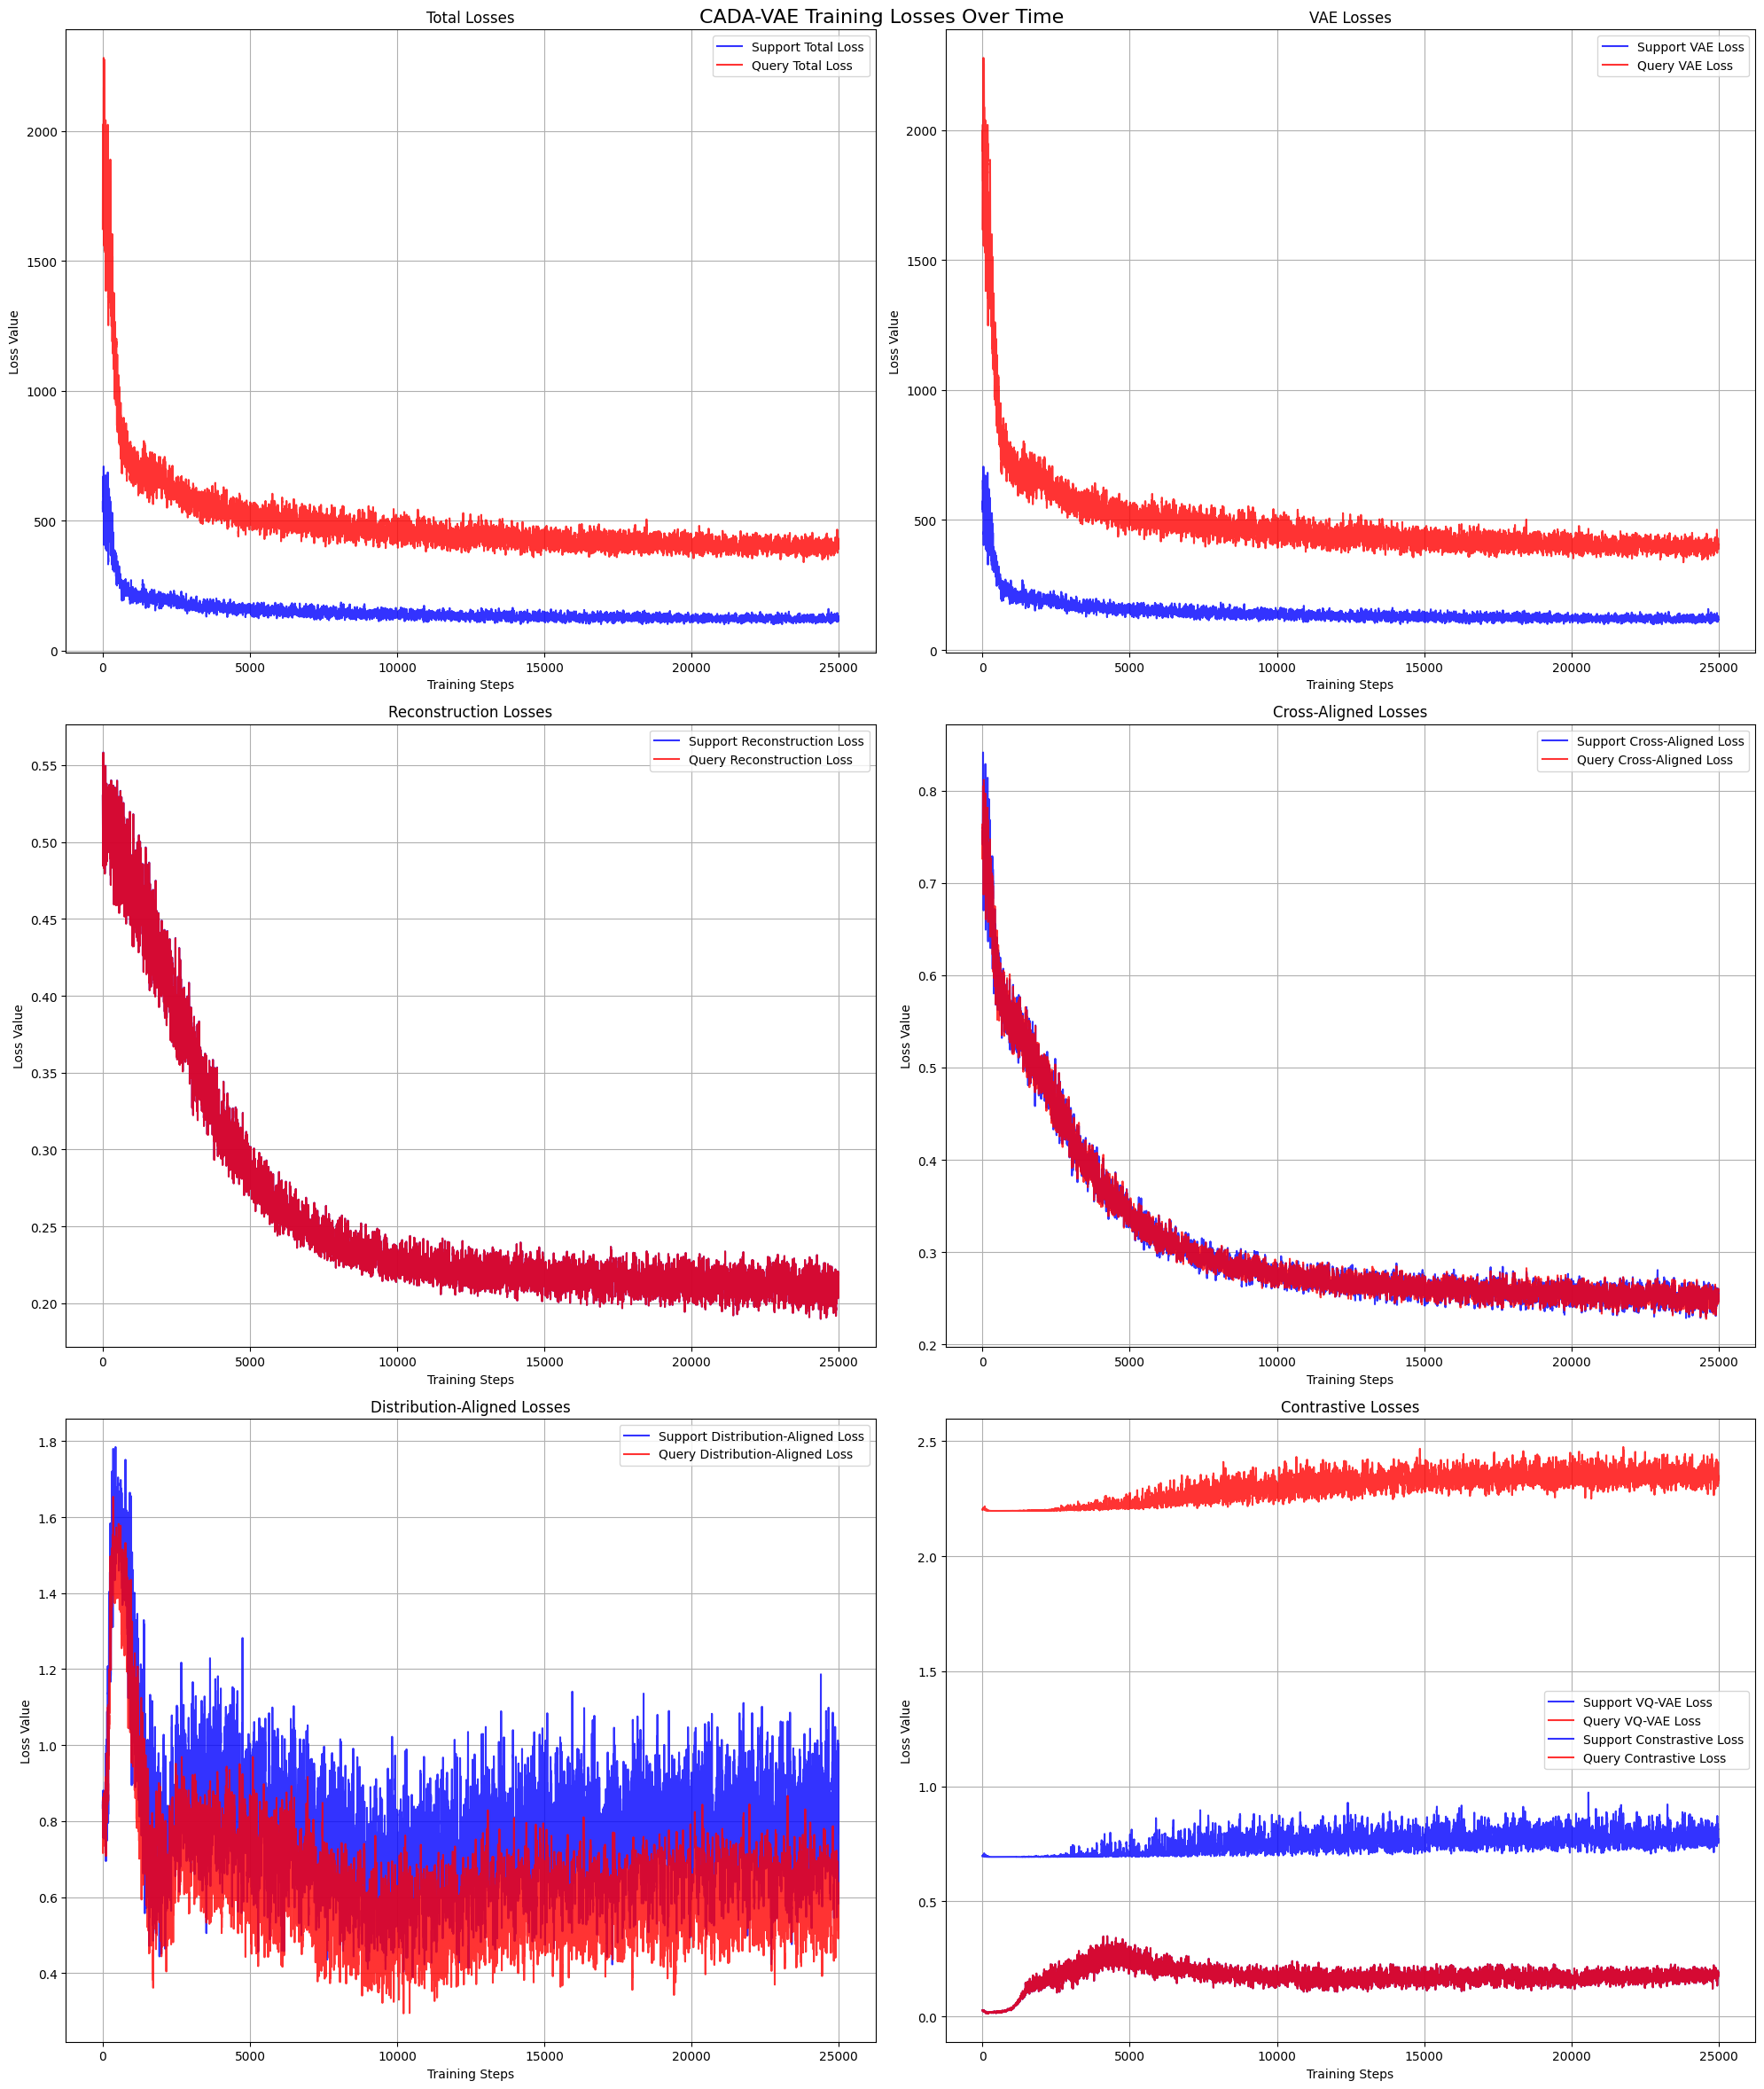

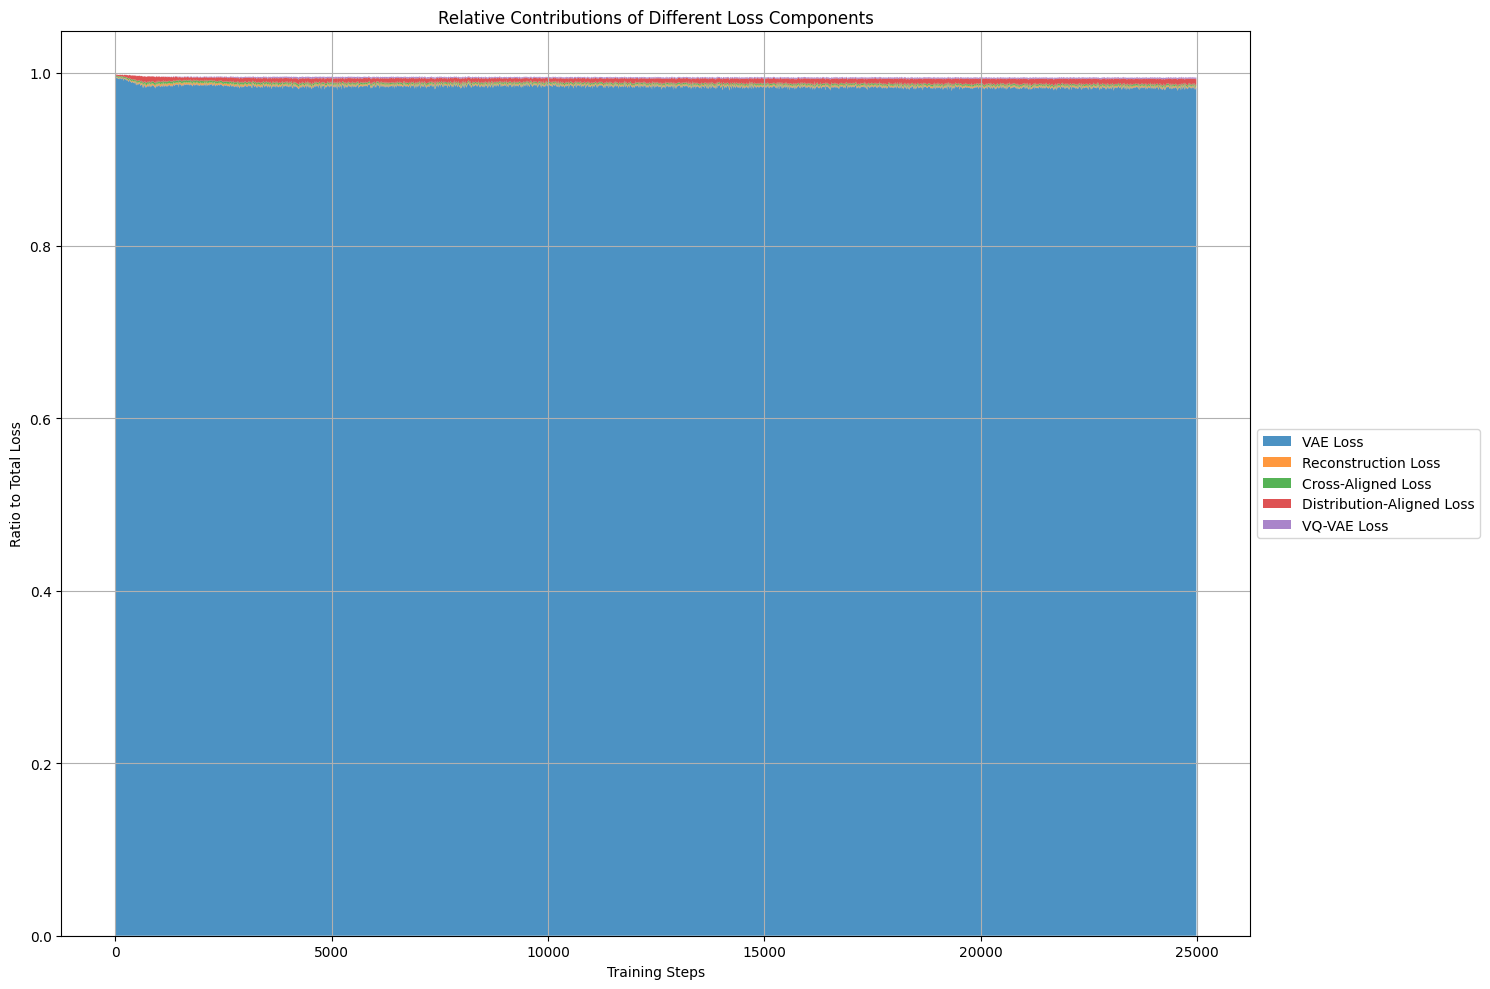


Loss Statistics Summary:
--------------------------------------------------

Total Loss:
Support - Mean: 119.3994, Std: 22.6154
Query  - Mean: 391.9821, Std: 56.2415

Vae Loss:
Support - Mean: 117.5122, Std: 22.5501
Query  - Mean: 389.3839, Std: 56.0382

Recon Loss C:
Support - Mean: 0.2187, Std: 0.0319
Query  - Mean: 0.2187, Std: 0.0319

Ca Loss:
Support - Mean: 0.2579, Std: 0.0323
Query  - Mean: 0.2572, Std: 0.0304

Mmd Loss:
Support - Mean: 0.5833, Std: 0.2658
Query  - Mean: 0.5222, Std: 0.2373

Vq Vae Loss:
Support - Mean: 0.1838, Std: 0.0477
Query  - Mean: 0.1838, Std: 0.0477


In [27]:
import matplotlib.pyplot as plt
import numpy as np

def plot_all_losses(loss_dict, num_tasks, epochs):
    """
    Create comprehensive visualizations of all tracked losses
    """
    # Set style
    plt.style.use('default')

    # Create subplots for different loss categories
    fig, axes = plt.subplots(3, 2, figsize=(20, 24))
    fig.suptitle('CADA-VAE Training Losses Over Time', size=16)

    # Calculate moving averages for smoother plots
    window_size = num_tasks

    def moving_average(data, window_size):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

    # Define colors for consistency
    support_color = 'blue'
    query_color = 'red'

    # Plot total losses
    ax = axes[0, 0]
    support_avg = moving_average(loss_dict['support_total_loss'], window_size)
    query_avg = moving_average(loss_dict['query_total_loss'], window_size)
    ax.plot(support_avg, label='Support Total Loss', color=support_color, alpha=0.8)
    ax.plot(query_avg, label='Query Total Loss', color=query_color, alpha=0.8)
    ax.set_title('Total Losses')
    ax.set_xlabel('Training Steps')
    ax.set_ylabel('Loss Value')
    ax.legend()
    ax.grid(True)

    # Plot VAE losses
    ax = axes[0, 1]
    support_vae_avg = moving_average(loss_dict['support_vae_loss'], window_size)
    query_vae_avg = moving_average(loss_dict['query_vae_loss'], window_size)
    ax.plot(support_vae_avg, label='Support VAE Loss', color=support_color, alpha=0.8)
    ax.plot(query_vae_avg, label='Query VAE Loss', color=query_color, alpha=0.8)
    ax.set_title('VAE Losses')
    ax.set_xlabel('Training Steps')
    ax.set_ylabel('Loss Value')
    ax.legend()
    ax.grid(True)

    # Plot Reconstruction losses
    ax = axes[1, 0]
    support_recon_avg = moving_average(loss_dict['support_recon_loss_c'], window_size)
    query_recon_avg = moving_average(loss_dict['query_recon_loss_c'], window_size)
    ax.plot(support_recon_avg, label='Support Reconstruction Loss', color=support_color, alpha=0.8)
    ax.plot(query_recon_avg, label='Query Reconstruction Loss', color=query_color, alpha=0.8)
    ax.set_title('Reconstruction Losses')
    ax.set_xlabel('Training Steps')
    ax.set_ylabel('Loss Value')
    ax.legend()
    ax.grid(True)

    # Plot Cross-Aligned losses
    ax = axes[1, 1]
    support_ca_avg = moving_average(loss_dict['support_ca_loss'], window_size)
    query_ca_avg = moving_average(loss_dict['query_ca_loss'], window_size)
    ax.plot(support_ca_avg, label='Support Cross-Aligned Loss', color=support_color, alpha=0.8)
    ax.plot(query_ca_avg, label='Query Cross-Aligned Loss', color=query_color, alpha=0.8)
    ax.set_title('Cross-Aligned Losses')
    ax.set_xlabel('Training Steps')
    ax.set_ylabel('Loss Value')
    ax.legend()
    ax.grid(True)

    # Plot Distribution-Aligned losses
    ax = axes[2, 0]
    support_da_avg = moving_average(loss_dict['support_mmd_loss'], window_size)
    query_da_avg = moving_average(loss_dict['query_mmd_loss'], window_size)
    ax.plot(support_da_avg, label='Support Distribution-Aligned Loss', color=support_color, alpha=0.8)
    ax.plot(query_da_avg, label='Query Distribution-Aligned Loss', color=query_color, alpha=0.8)
    ax.set_title('Distribution-Aligned Losses')
    ax.set_xlabel('Training Steps')
    ax.set_ylabel('Loss Value')
    ax.legend()
    ax.grid(True)

    # Plot VQ-VAE losses
    ax = axes[2, 1]
    support_vq_avg = moving_average(loss_dict['support_vq_vae_loss'], window_size)
    query_vq_avg = moving_average(loss_dict['query_vq_vae_loss'], window_size)
    ax.plot(support_vq_avg, label='Support VQ-VAE Loss', color=support_color, alpha=0.8)
    ax.plot(query_vq_avg, label='Query VQ-VAE Loss', color=query_color, alpha=0.8)
    ax.set_title('VQ-VAE Losses')
    ax.set_xlabel('Training Steps')
    ax.set_ylabel('Loss Value')
    ax.legend()
    ax.grid(True)

    # Plot VQ-VAE losses
    ax = axes[2, 1]
    support_vq_avg = moving_average(loss_dict['support_contrast_loss'], window_size)
    query_vq_avg = moving_average(loss_dict['query_contrast_loss'], window_size)
    ax.plot(support_vq_avg, label='Support Constrastive Loss', color=support_color, alpha=0.8)
    ax.plot(query_vq_avg, label='Query Contrastive Loss', color=query_color, alpha=0.8)
    ax.set_title('Contrastive Losses')
    ax.set_xlabel('Training Steps')
    ax.set_ylabel('Loss Value')
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()

def plot_loss_ratios(loss_dict, num_tasks, epochs):
    """
    Plot the ratios between different loss components to analyze their relative contributions
    """
    plt.figure(figsize=(15, 10))

    # Calculate moving averages
    window_size = num_tasks

    def moving_average(data, window_size):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

    # Calculate ratios of different losses to total loss
    total_loss_avg = moving_average(loss_dict['support_total_loss'], window_size)
    vae_ratio = moving_average(loss_dict['support_vae_loss'], window_size) / total_loss_avg
    recon_ratio = moving_average(loss_dict['support_recon_loss_c'], window_size) / total_loss_avg
    ca_ratio = moving_average(loss_dict['support_ca_loss'], window_size) / total_loss_avg
    da_ratio = moving_average(loss_dict['support_mmd_loss'], window_size) / total_loss_avg
    vq_ratio = moving_average(loss_dict['support_vq_vae_loss'], window_size) / total_loss_avg

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

    plt.stackplot(range(len(vae_ratio)),
                 [vae_ratio, recon_ratio, ca_ratio, da_ratio, vq_ratio],
                 labels=['VAE Loss', 'Reconstruction Loss', 'Cross-Aligned Loss',
                        'Distribution-Aligned Loss', 'VQ-VAE Loss'],
                 colors=colors,
                 alpha=0.8)

    plt.title('Relative Contributions of Different Loss Components')
    plt.xlabel('Training Steps')
    plt.ylabel('Ratio to Total Loss')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def analyze_loss_statistics(loss_dict, num_tasks):
    """
    Print statistical analysis of the losses
    """
    print("\nLoss Statistics Summary:")
    print("-" * 50)

    # Calculate statistics for each loss type
    loss_types = ['total_loss', 'vae_loss', 'recon_loss_c', 'ca_loss', 'mmd_loss', 'vq_vae_loss']

    for loss_type in loss_types:
        support_key = f'support_{loss_type}'
        query_key = f'query_{loss_type}'

        support_data = np.array(loss_dict[support_key][-num_tasks:])
        query_data = np.array(loss_dict[query_key][-num_tasks:])

        print(f"\n{loss_type.replace('_', ' ').title()}:")
        print(f"Support - Mean: {np.mean(support_data):.4f}, Std: {np.std(support_data):.4f}")
        print(f"Query  - Mean: {np.mean(query_data):.4f}, Std: {np.std(query_data):.4f}")

# Usage example:
# After training completes:
plot_all_losses(loss_dict, num_tasks, epochs)
plot_loss_ratios(loss_dict, num_tasks, epochs)
analyze_loss_statistics(loss_dict, num_tasks)

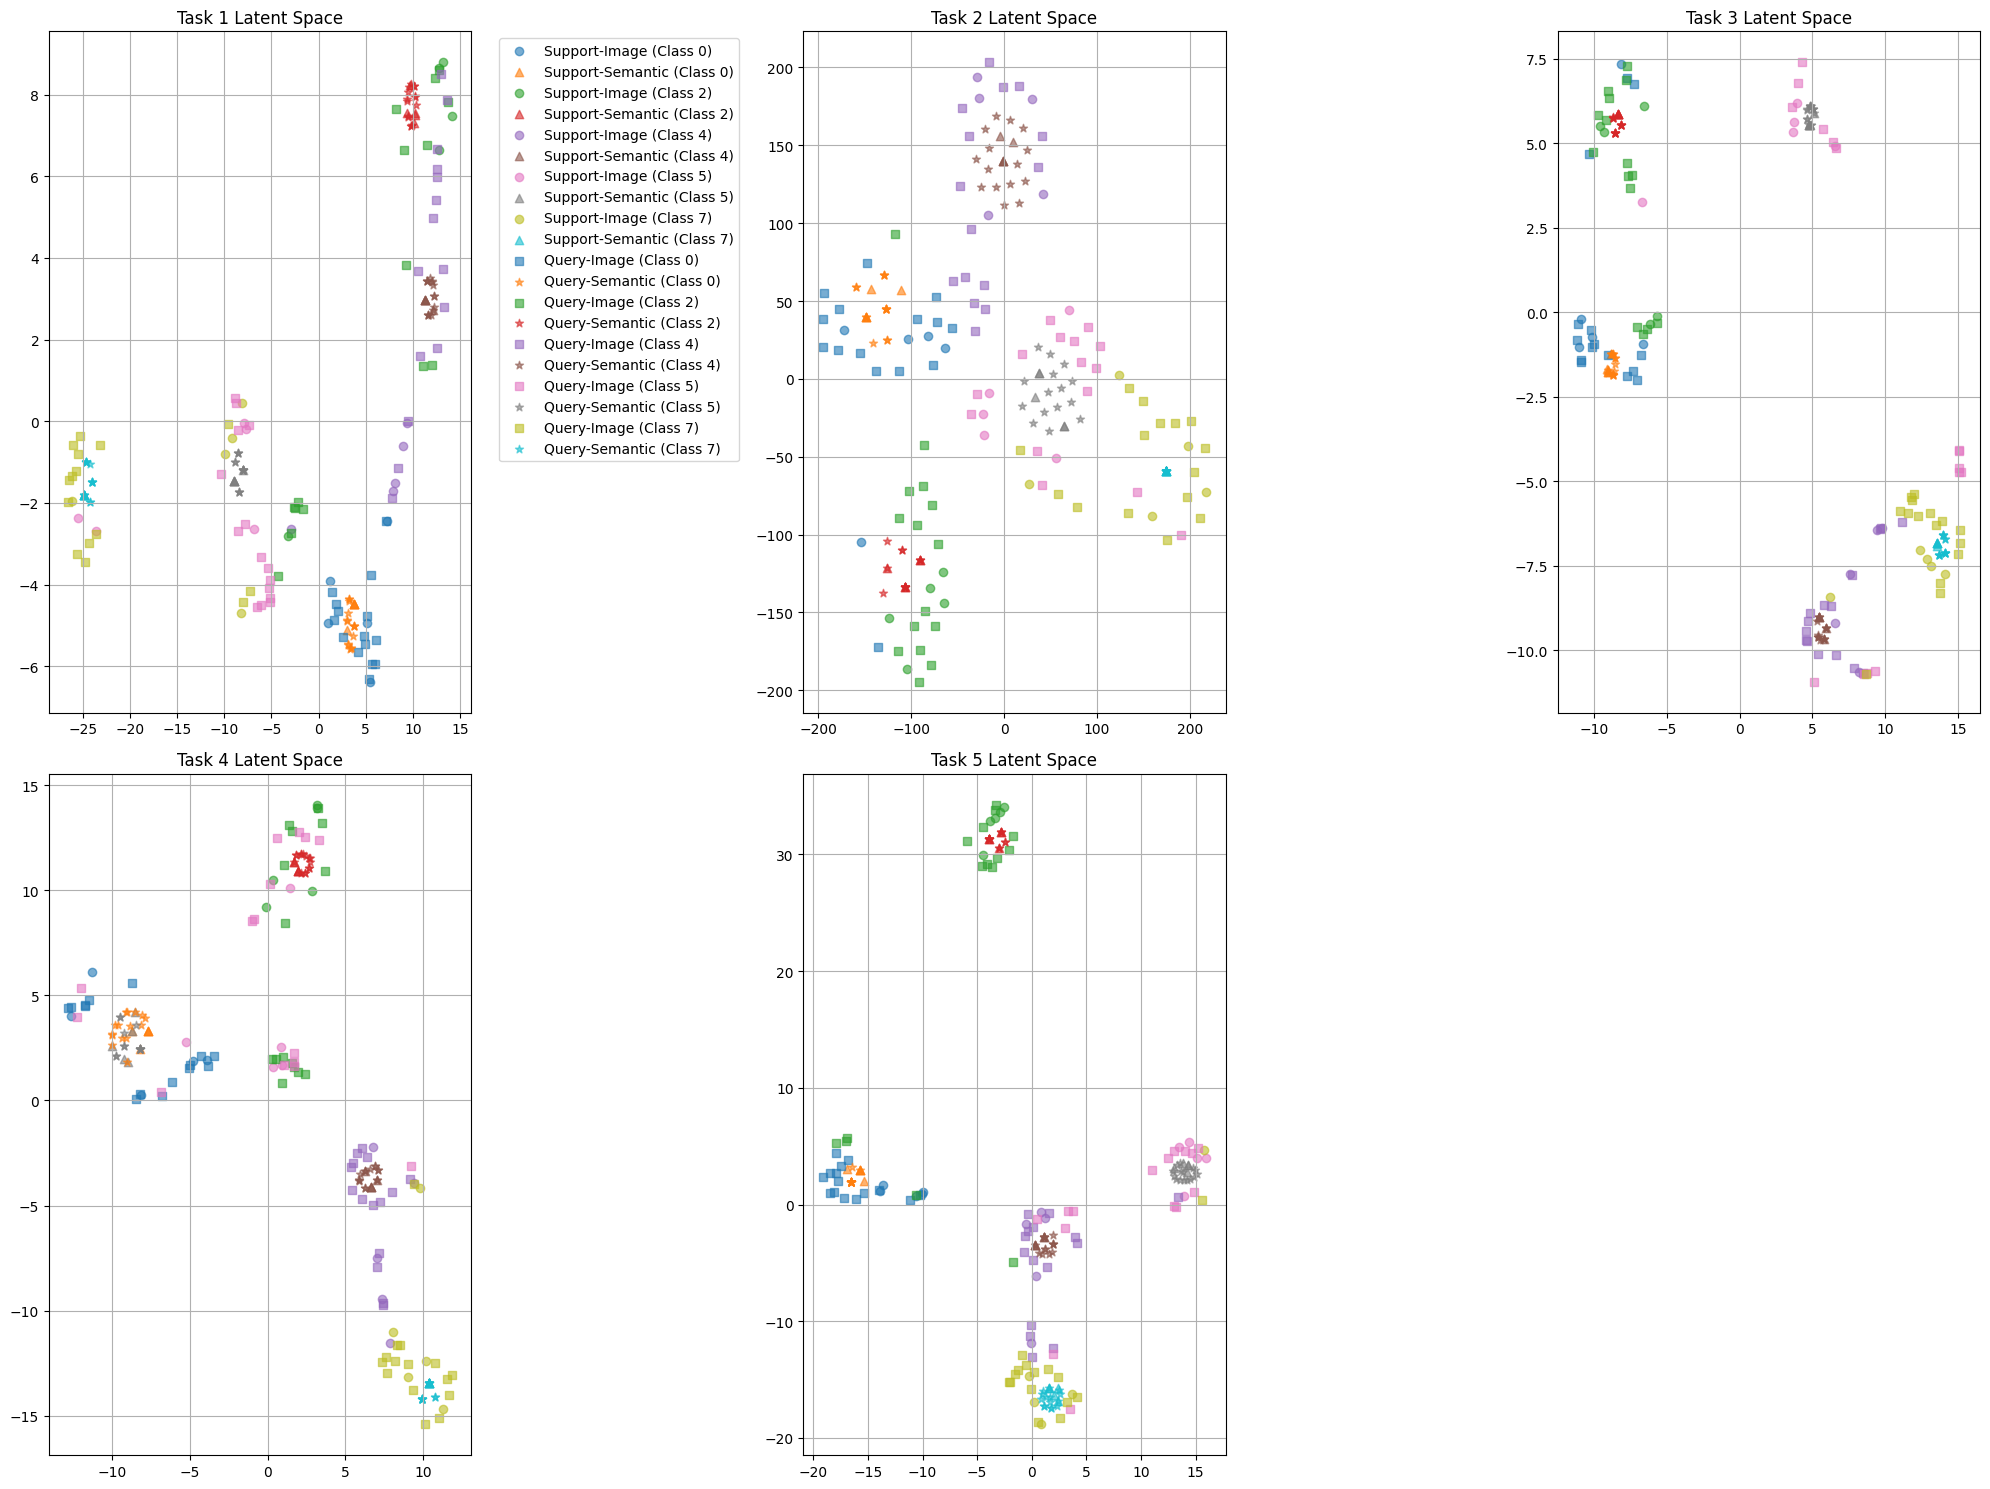

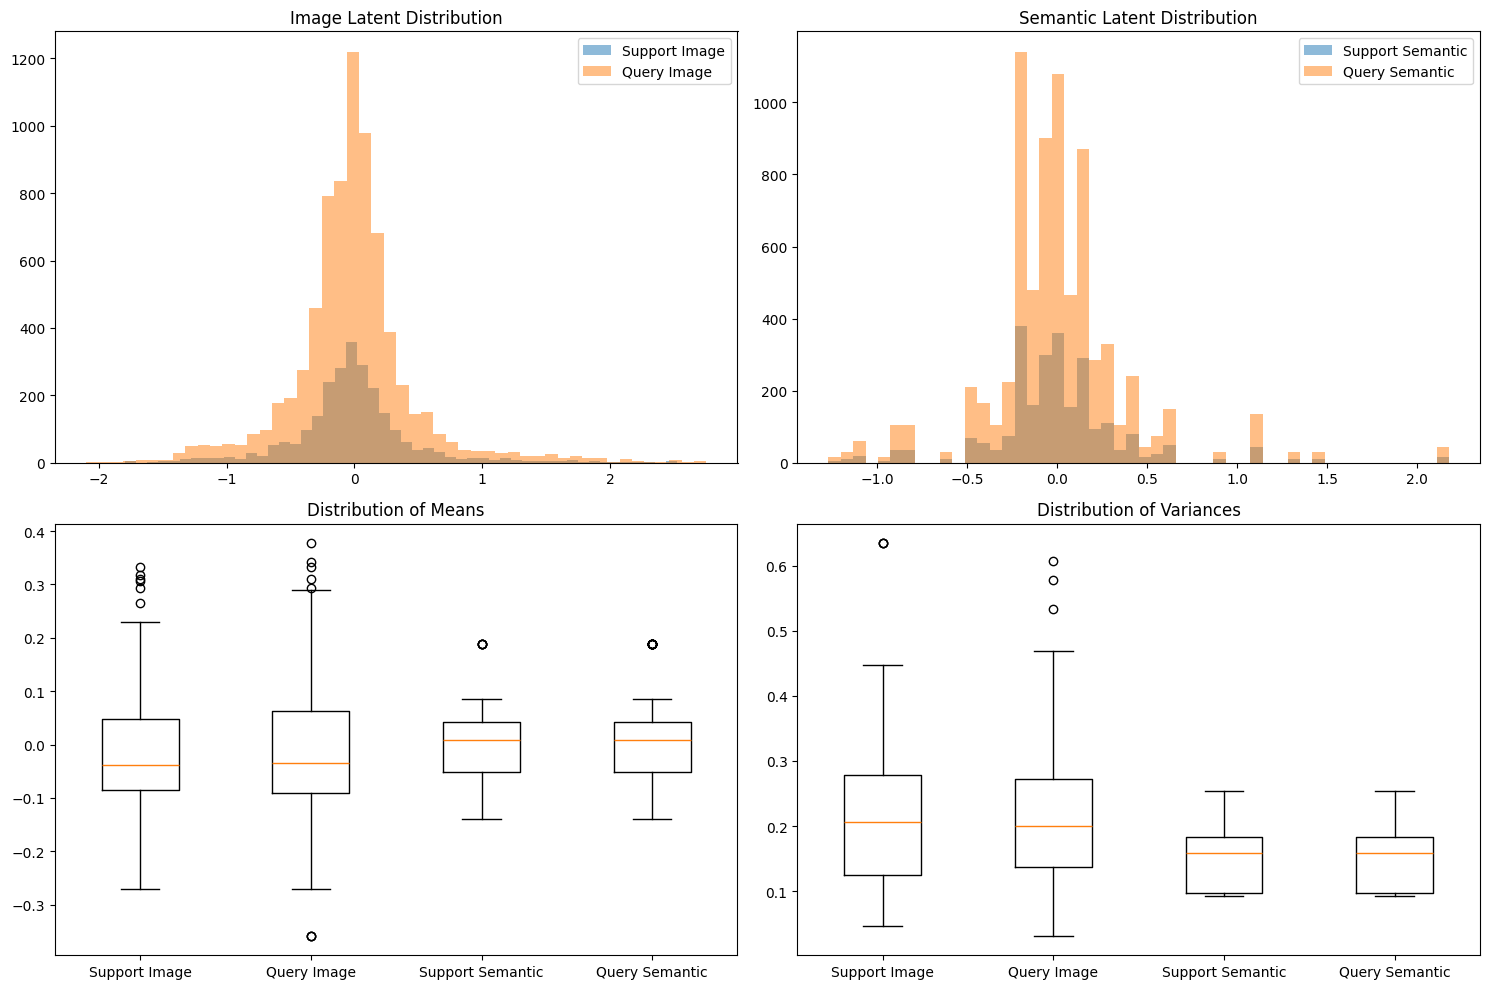

In [29]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import numpy as np

def collect_latent_representations(model, dataset, indices, word_vectors, device):
    """Collect latent representations for a given set of indices"""
    model.eval()
    all_image_latent = []
    all_semantic_latent = []
    all_labels = []

    with torch.no_grad():
        for idx in indices:
            data, target = dataset[idx]
            data = data.unsqueeze(0).to(device)  # Add batch dimension
            semantic_embedding = get_semantic_embedding([target], word_vectors).to(device)

            # Get latent representations
            mu_x, logvar_x = model.image_encoder(data)
            mu_c, logvar_c, z_q, z_e, _, _ = model.semantic_encoder(semantic_embedding)

            # Store image and semantic latent vectors
            all_image_latent.append(mu_x.cpu())
            all_semantic_latent.append(z_e.cpu())
            all_labels.append(target)

    return (torch.cat(all_image_latent, dim=0).numpy(),
            torch.cat(all_semantic_latent, dim=0).numpy(),
            np.array(all_labels))

def visualize_meta_latent_space(model, dataset, num_tasks=5, num_support=5, num_query=15):
    """Visualize latent space distributions for meta-learning tasks"""
    plt.figure(figsize=(20, 15))

    for task_idx in range(num_tasks):
        # Sample a task
        support_indices, query_indices = sample_task(dataset, num_support=num_support, num_query=num_query)

        # Collect latent representations
        support_image_latent, support_semantic_latent, support_labels = collect_latent_representations(
            model, dataset, support_indices, word_vectors, device)
        query_image_latent, query_semantic_latent, query_labels = collect_latent_representations(
            model, dataset, query_indices, word_vectors, device)

        # Combine all latent representations for t-SNE
        combined_latent = np.vstack([
            support_image_latent, support_semantic_latent,
            query_image_latent, query_semantic_latent
        ])

        # Perform t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        latent_2d = tsne.fit_transform(combined_latent)

        # Split back into separate components
        n_support = len(support_indices)
        n_query = len(query_indices)
        support_image_2d = latent_2d[:n_support]
        support_semantic_2d = latent_2d[n_support:2*n_support]
        query_image_2d = latent_2d[2*n_support:2*n_support+n_query]
        query_semantic_2d = latent_2d[2*n_support+n_query:]

        # Create subplot for this task
        plt.subplot(2, 3, task_idx + 1)

        # Plot support set
        for label in np.unique(support_labels):
            mask = support_labels == label
            plt.scatter(support_image_2d[mask, 0], support_image_2d[mask, 1],
                       marker='o', label=f'Support-Image (Class {label})', alpha=0.6)
            plt.scatter(support_semantic_2d[mask, 0], support_semantic_2d[mask, 1],
                       marker='^', label=f'Support-Semantic (Class {label})', alpha=0.6)

        # Plot query set
        for label in np.unique(query_labels):
            mask = query_labels == label
            plt.scatter(query_image_2d[mask, 0], query_image_2d[mask, 1],
                       marker='s', label=f'Query-Image (Class {label})', alpha=0.6)
            plt.scatter(query_semantic_2d[mask, 0], query_semantic_2d[mask, 1],
                       marker='*', label=f'Query-Semantic (Class {label})', alpha=0.6)

        plt.title(f'Task {task_idx + 1} Latent Space')
        if task_idx == 0:  # Only show legend for first subplot
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_latent_distributions(model, dataset, num_tasks=5, num_support=5, num_query=15):
    """Plot distributions of latent variables for different components"""
    plt.figure(figsize=(15, 10))

    all_support_image = []
    all_support_semantic = []
    all_query_image = []
    all_query_semantic = []

    for _ in range(num_tasks):
        support_indices, query_indices = sample_task(dataset, num_support=num_support, num_query=num_query)

        # Collect latent representations
        support_image_latent, support_semantic_latent, _ = collect_latent_representations(
            model, dataset, support_indices, word_vectors, device)
        query_image_latent, query_semantic_latent, _ = collect_latent_representations(
            model, dataset, query_indices, word_vectors, device)

        all_support_image.append(support_image_latent)
        all_support_semantic.append(support_semantic_latent)
        all_query_image.append(query_image_latent)
        all_query_semantic.append(query_semantic_latent)

    # Combine all tasks
    support_image = np.vstack(all_support_image)
    support_semantic = np.vstack(all_support_semantic)
    query_image = np.vstack(all_query_image)
    query_semantic = np.vstack(all_query_semantic)

    # Plot distributions
    plt.subplot(2, 2, 1)
    plt.hist(support_image.flatten(), bins=50, alpha=0.5, label='Support Image')
    plt.hist(query_image.flatten(), bins=50, alpha=0.5, label='Query Image')
    plt.title('Image Latent Distribution')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.hist(support_semantic.flatten(), bins=50, alpha=0.5, label='Support Semantic')
    plt.hist(query_semantic.flatten(), bins=50, alpha=0.5, label='Query Semantic')
    plt.title('Semantic Latent Distribution')
    plt.legend()

    # Plot mean and variance
    plt.subplot(2, 2, 3)
    plt.boxplot([
        support_image.mean(axis=1),
        query_image.mean(axis=1),
        support_semantic.mean(axis=1),
        query_semantic.mean(axis=1)
    ], labels=['Support Image', 'Query Image', 'Support Semantic', 'Query Semantic'])
    plt.title('Distribution of Means')

    plt.subplot(2, 2, 4)
    plt.boxplot([
        support_image.var(axis=1),
        query_image.var(axis=1),
        support_semantic.var(axis=1),
        query_semantic.var(axis=1)
    ], labels=['Support Image', 'Query Image', 'Support Semantic', 'Query Semantic'])
    plt.title('Distribution of Variances')

    plt.tight_layout()
    plt.show()

# Usage example:
visualize_meta_latent_space(model, train_dataset)
plot_latent_distributions(model, train_dataset)

In [ ]:
import numpy as np
import cv2
def sharpen_image(image):
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
    sharpened = cv2.filter2D(image, -1, kernel)
    return np.clip(sharpened, 0, 1)  # Ensure values are in range


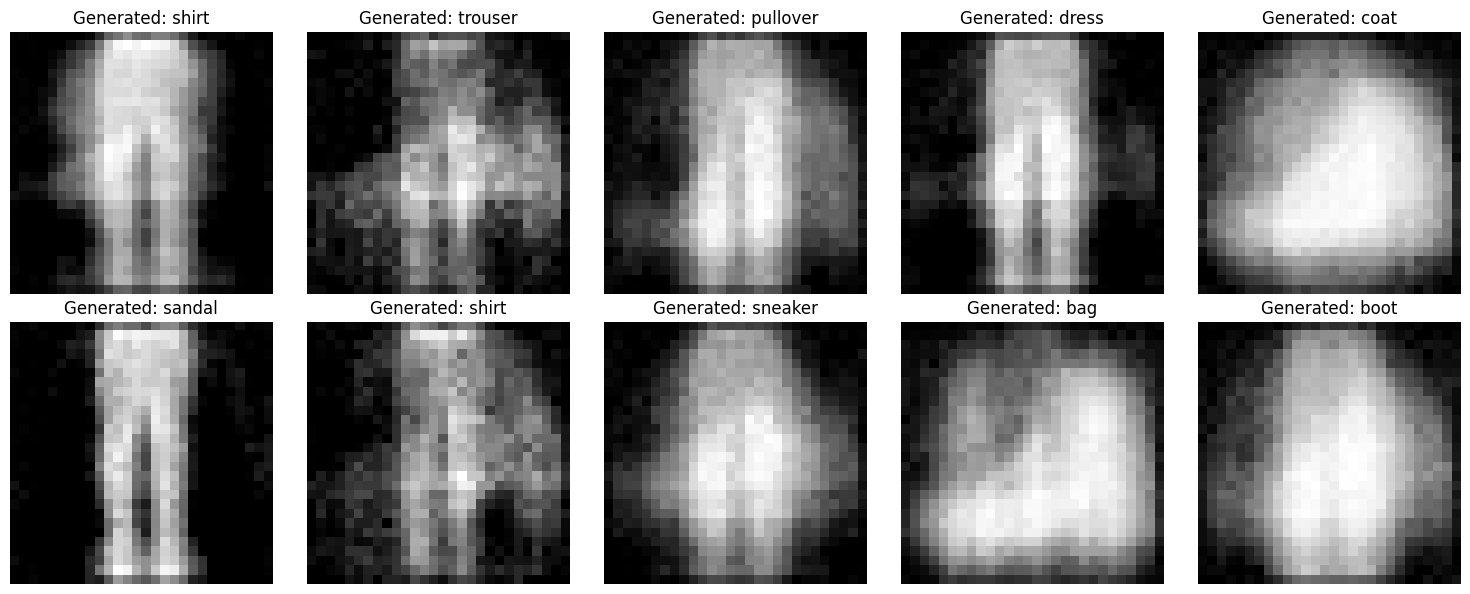

In [40]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def generate_images_from_semantic_embeddings_fashionMnist(model, word_vectors, device, classes):
    model.eval()  # Set the model to evaluation mode

    generated_images = []

    for cls in classes:
        # Get the semantic embedding for the class
        embedding = word_vectors[cls]

        # Convert embedding to tensor and move to device
        embedding_tensor = torch.tensor(embedding).unsqueeze(0).to(device)  # Add batch dimension

        with torch.no_grad():
            # Forward pass through the semantic encoder
            mu_c, logvar_c, z_q, z_e, quantization_loss, commitment_loss = model.semantic_encoder(embedding_tensor)

            # Reparameterize the latent space using mu_c and logvar_c (if needed)
            latent_c = model.reparameterize(mu_c, logvar_c)

            # Decode the latent representation to generate the image
            generated_image = model.image_decoder(latent_c)

        # Reshape and clip/store the generated image
        generated_image = generated_image.view(28, 28).cpu().numpy()  # Reshape to (28, 28)
        # Normalize the image values to [0, 1] range if they are in float
        generated_image = np.clip(generated_image, 0, 1)  # Ensure the values are in [0, 1]

        generated_images.append(generated_image)

    return generated_images


# Function to plot the generated images
def plot_generated_images_fashionmnist(generated_images, class_names):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        ax.imshow(generated_images[i], cmap='gray')
        ax.set_title(f'Generated: {class_names[i]}')
        ax.axis('off')  # Turn off axis labels

    plt.tight_layout()
    plt.show()

# Assuming you have a list of fashion_mnist_classes
# Generate images using semantic embeddings
generated_images = generate_images_from_semantic_embeddings_fashionMnist(model, word_vectors, device, fashion_mnist_classes)

# Plot the generated images
plot_generated_images_fashionmnist(generated_images, fashion_mnist_classes)


Generated image shape: (28, 28)


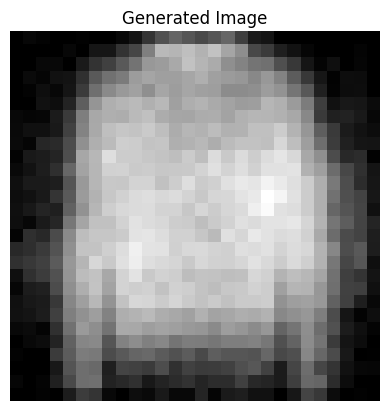

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Function to visualize the generated image
def visualize_generated_image(generated_image):
    # Print the shape of the generated image for debugging
    print("Generated image shape:", generated_image.shape)

    # If the image is already 2D (grayscale), no need to transpose
    # Rescale the pixel values to [0, 1]
    generated_image = np.clip(generated_image, 0, 1)  # Ensure the values are in [0, 1]

    # Display the image
    plt.imshow(generated_image, cmap='gray')  # Use 'gray' colormap for grayscale images
    plt.axis('off')  # Hide axes
    plt.title('Generated Image')
    plt.show()

# Generate images using semantic embeddings
generated_images = generate_images_from_semantic_embeddings_fashionMnist(model, word_vectors, device, fashion_mnist_classes)

# Visualize the first generated image (assuming it's an image from fashion_mnist_classes)
visualize_generated_image(generated_images[5])
